In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
import matplotlib.pyplot as plt
from PIL import Image

import zipfile

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import tqdm

In [3]:
# Extracting data
train_dir = "/kaggle/input/dogs-vs-cats/train.zip"
test_dir = "/kaggle/input/dogs-vs-cats/test1.zip"

with zipfile.ZipFile(train_dir,"r") as z:
    z.extractall(".")
    
with zipfile.ZipFile(test_dir,"r") as z:
    z.extractall(".")

In [4]:
train_dir = "/kaggle/working/train"
test_dir = "/kaggle/working/test1"

train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [5]:
class DogCatDataset(Dataset):
    def __init__(self, file_list, dir, mode= 'train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode = mode
        self.transform = transform
        
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
                
    def __len__(self):
        length = len(self.file_list)
        return length
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        
        if self.transform:
            img = self.transform(img)
            
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]
        
        
        
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats= DogCatDataset(cat_files, train_dir, transform = data_transform)
dogs= DogCatDataset(dog_files, train_dir, transform = data_transform)

catdogs = ConcatDataset([cats, dogs])

In [6]:
dataloader = DataLoader(catdogs, batch_size= 32, shuffle= True,
                       num_workers=4)

#samples, labels = iter(dataloader).next()

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torchvision.models.densenet121(pretrained= True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [8]:
num_features = model.classifier.in_features
model.classifier = nn.Sequential(
                    nn.Linear(num_features, 500),
                    nn.Linear(500, 2)
)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)

Running for epoch 1/3
[Epoch 1/3] Iteration 200 -> Train Loss: 0.4603, Accuracy: 0.812
[Epoch 1/3] Iteration 400 -> Train Loss: 0.3167, Accuracy: 0.719
[Epoch 1/3] Iteration 600 -> Train Loss: 0.2314, Accuracy: 0.875
Running for epoch 2/3
[Epoch 2/3] Iteration 800 -> Train Loss: 0.1840, Accuracy: 0.938
[Epoch 2/3] Iteration 1000 -> Train Loss: 0.1716, Accuracy: 0.906
[Epoch 2/3] Iteration 1200 -> Train Loss: 0.1406, Accuracy: 0.938
[Epoch 2/3] Iteration 1400 -> Train Loss: 0.1320, Accuracy: 0.938
Running for epoch 3/3
[Epoch 3/3] Iteration 1600 -> Train Loss: 0.1168, Accuracy: 0.969
[Epoch 3/3] Iteration 1800 -> Train Loss: 0.0998, Accuracy: 1.000
[Epoch 3/3] Iteration 2000 -> Train Loss: 0.0985, Accuracy: 0.969
[Epoch 3/3] Iteration 2200 -> Train Loss: 0.0986, Accuracy: 0.969


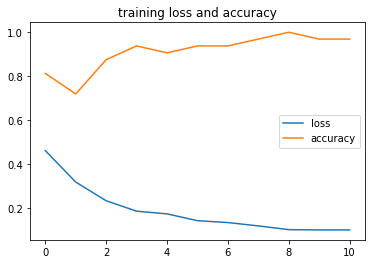

In [9]:
epochs = 3
itr = 1
p_itr = 200
train_oss = 0
loss_list = []
acc_list = []
iter_loss = []
total_loss = 0


for epoch in range(epochs):
    print("Running for epoch {}/{}".format(epoch+1, epochs))
    for samples, labels in dataloader:
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output, labels)
        loss.backward()
        iter_loss.append(loss)
        optimizer.step()
        total_loss += loss.item()
        scheduler.step()    
        
        if itr%p_itr == 0:
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'
                  .format(epoch+1, epochs, itr, total_loss/p_itr, acc))
            loss_list.append(total_loss/p_itr)
            acc_list.append(acc)
            total_loss = 0
            
        itr += 1
            
plt.plot(loss_list, label='loss')
plt.plot(acc_list, label='accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.show()

In [10]:
plt.savefig('Performance.png')
filename_pth = 'ckpt_densenet121_catdog.pth'
torch.save(model.state_dict(), filename_pth)

<Figure size 432x288 with 0 Axes>

In [11]:
### Loading the model
#model = torchvision.models.densenet121(pretrained= False)
#model.load_state_dict(torch.load(PATH))
#model.eval()

In [12]:
# train_dir = '../input/train/train'
# test_dir = '../input/test1/test1'
# train_files = os.listdir(train_dir)
# test_files = os.listdir(test_dir)